In [1]:
import sys
import os

project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.append(project_root)

%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from src.features import build_features
from src.visualization import visualize

sns.set_theme(palette="pastel")
plt.rcParams["figure.figsize"] = (12, 6)

# Asumiendo que es una ocupacion del 80% de camas
INDICE_OCUPACION_CAMAS = 1.25

# Proyección de casos INT al 2035

En este cuadernillo se quiere estimar la deminada que atenderá el INT para el 2035. Con esta demanada se calcularán las cantidades de camas necesarias para suplir tal demanda. Para determinar la demanda se utilizarán:

1. Cantidad de casos teóricos por problemas de salud relevantes seleccionados: Estos se calcularon según la incidencia de cada problema de salud y la proyección de la población al 2035.

2. Cantidad de casos atendidos actualmente por cada problema de salud: Estos se obtuvieron al analizar la base de egresos hospitalarios DEIS.

Con ambos datos, se obtendrá cuanto % de atención ha cubierto el INT de los casos teóricos.

## Obtencion de casos teoricos para cada diagnóstico relevante segun incidencia

Estos seran obtenidos desde el cuadernillo 1.0-jrb-number-of-persons-per-strata

In [3]:
# Importa los casos teoricos por cada problema de salud
casos_teoricos = pd.read_excel("../data/interim/casos_teoricos_diagnosticos.xlsx")
casos_teoricos["Diagnostico"] = casos_teoricos["Diagnostico"].str.split("-").str[0].str.strip()

# Extrae los diagnosticos relevantes para el recinto hospitalario
DIAGNOSTICOS_RELEVANTES = casos_teoricos["Diagnostico"].unique()
casos_teoricos = casos_teoricos.set_index("Diagnostico")

# Renombra columnas
COLUMNAS_A_RENOMBRAR = {
    "Poblacion 2017": 2017,
    "Poblacion 2018": 2018,
    "Poblacion 2019": 2019,
    "Poblacion 2020": 2020,
    "Poblacion 2021": 2021,
    "Poblacion 2022": 2022,
    "Poblacion 2023": 2023,
    "Poblacion 2024": 2024,
    "Poblacion 2025": 2025,
    "Poblacion 2026": 2026,
    "Poblacion 2027": 2027,
    "Poblacion 2028": 2028,
    "Poblacion 2029": 2029,
    "Poblacion 2030": 2030,
    "Poblacion 2031": 2031,
    "Poblacion 2032": 2032,
    "Poblacion 2033": 2033,
    "Poblacion 2034": 2034,
    "Poblacion 2035": 2035,
}
casos_teoricos = casos_teoricos.rename(columns=COLUMNAS_A_RENOMBRAR)

# Obtiene los casos en el estrato nacional
casos_pais = casos_teoricos.query("Estrato == 'Pais'").copy().sort_index()
casos_pais_del_2017_al_2020 = casos_pais[[i for i in range(2017, 2020)]]

In [4]:
print(
    f"Los diagnosticos que seran proyectados son: \n{DIAGNOSTICOS_RELEVANTES} "
    f"\ny son {len(DIAGNOSTICOS_RELEVANTES)}"
)

Los diagnosticos que seran proyectados son: 
['A152' 'B441' 'C341' 'C342' 'C343' 'C381' 'C780' 'C782' 'D381' 'E848'
 'I051' 'I052' 'I080' 'I081' 'I232' 'I330' 'I340' 'I350' 'I351' 'I352'
 'I361' 'I420' 'I421' 'I495' 'I710' 'I711' 'I712' 'I715' 'J679' 'J841'
 'J848' 'J955' 'M051' 'M348' 'Q222' 'Q233' 'Q257' 'Z450'] 
y son 38


## Obtención de casos atendidos entre 2017 y 2020 para diagnósticos relevantes.

Estos se obtendrán del análisis de egresos hospitalarios a nivel país DEIS.

In [5]:
# Carga los egresos nacionales
egresos_nacionales = pd.read_csv(
    "../data/processed/ranking_nacional_egresos.csv", sep=";", encoding="latin-1"
)

# Filtra solamente los datos del INT
egresos_torax = egresos_nacionales.query("ESTABLECIMIENTO_SALUD == 112103").copy()

En primer lugar, se filtrarán ambas bases de datos para solamente tener la información de los diagnósticos más relevantes para el INT. Luego de esto, se calculará la cantidad de egresos, dias de estada y pacientes para cada uno de los diagnósticos. Estos insumos serán utilizados para estimar la demanda.


In [6]:
# Filtra solamente los diagnosticos mas relevantes del Torax
egresos_mas_relevantes_nacionales = (
    egresos_nacionales[egresos_nacionales["DIAG1"].isin(DIAGNOSTICOS_RELEVANTES)]
    .query("ANO_EGRESO >= 2017 and ANO_EGRESO <= 2019")
    .copy()
)

Previo a calcular las métricas para cada diagnóstico, es necesario agrupar algunos de ellos. Esto se debe a que ciertas incidencias fueron imposible de encontrar, como por ejemplo con:

- **I052 - Estenosis mitral con insuficiencia**: El 100% de los egresos y cantidad de pacientes será asignado al diagnóstico I051 - Insuficiencia mitral reumática. Sólamente se calculará la cantidad de casos teóricos para la insuficiencia mitral reumática.

- **I080 - Trastornos de las válvulas mitral y aórtica**: El 100% de los egresos y cantidad de pacientes será asignado al diagnóstico I340 - Insuficiencia (de la válvula) mitral y I350 - Estenosis (de la válvula) aórtica.

- **I081 - Trastornos de las válvulas mitral y tricúspide**: El 100% de los egresos y cantidad de pacientes será asignado al diagnóstico I340 - Insuficiencia (de la válvula) mitral y I361 - Insuficiencia no reumática (de la válvula) tricúspide.

In [7]:
# Reasigna I052
egresos_mas_relevantes_nacionales["DIAG1"] = (
    egresos_mas_relevantes_nacionales["DIAG1"].replace({"I052": "I051"}).copy()
)

# Reasigna I080 a I340 y I350 (Estenosis Mitral y Aortica, respectivamente)
egresos_mas_relevantes_nacionales = build_features.assign_diagnosis(
    egresos_mas_relevantes_nacionales, "I080", "I340", "I350"
)

# Reasigna I081 a I340 y I361 (Estenosis Mitral, y Valvulopatia Tricuspide)
egresos_mas_relevantes_nacionales = build_features.assign_diagnosis(
    egresos_mas_relevantes_nacionales, "I081", "I340", "I361"
)

In [8]:
# Filtra solamente los diagnosticos relevantes para el torax
egresos_mas_relevantes_torax = egresos_mas_relevantes_nacionales.query(
    "ESTABLECIMIENTO_SALUD == 112103"
).copy()

In [21]:
metricas_diags_relevantes_torax["n_pacientes_distintos"]

,2017,2018,2019
DIAG1,,,
A152,5,4,5
B441,4,2,8
C341,139,169,176
C342,16,20,19
C343,100,96,90
C381,13,18,19
C780,52,54,52
C782,27,48,34
D381,32,71,80


In [9]:
# Obtiene el resumen de metricas para el estrato nacional
metricas_diags_relevantes_nacionales = build_features.calculate_discharges_metrics(
    egresos_mas_relevantes_nacionales
)

# Obtiene resumen de metricas para el Torax
metricas_diags_relevantes_torax = build_features.calculate_discharges_metrics(
    egresos_mas_relevantes_torax
)

Solamente se compararán los casos reales vs teóricos entre 2017 y 2020, ya que la información se encuentra disponible en tales periodos.

En primer lugar, se obtendrá el porcentaje de atención del INT del total de casos teóricos. O sea:

$$\%atencion = \frac{Casos Reales}{Casos Teoricos}$$

La cantidad de casos están desglosados por año, por lo que es posible calcular un porcentaje de atención anual. Sin embargo, para efectos de cálculo, se obtendrá el porcentaje acumulado entre los años disponibles (2017 a 2020).

$$\%Atencion\ Acumulada = \frac{\sum_{2017}^{2020}Casos Reales}{\sum_{2017}^{2020}Casos Teoricos}$$

In [10]:
round(casos_pais_del_2017_al_2020).astype(int)

,2017,2018,2019
Diagnostico,,,
A152,2450,2494,2541
B441,3960,4032,4108
C341,7368,7501,7643
C342,7368,7501,7643
C343,7368,7501,7643
C381,221,225,229
C780,7368,7501,7643
C782,7368,7501,7643
D381,7368,7501,7643


In [11]:
(metricas_diags_relevantes_torax["n_egresos"] / casos_pais_del_2017_al_2020) * 100

,2017,2018,2019
A152,0.244923,4.290405,0.472207
B441,0.101007,0.049609,0.219082
C341,2.443104,2.933114,2.878494
C342,0.257883,0.319976,0.261681
C343,1.601590,1.653209,1.570087
C381,6.786400,9.332634,8.286573
C780,0.773650,0.839937,0.811212
C782,0.393611,0.706614,0.510278
D381,0.488621,1.133248,1.269154
E848,100.778416,138.502730,160.646366


In [12]:
metricas_diags_relevantes_torax["n_egresos"]

,2017,2018,2019
DIAG1,,,
A152,6,107,12
B441,4,2,9
C341,180,220,220
C342,19,24,20
C343,118,124,120
C381,15,21,19
C780,57,63,62
C782,29,53,39
D381,36,85,97


In [13]:
# Obtiene cuanto se hace cargo el INT de los pacientes teoricos
porcentaje_atencion_teorica_int = (
    metricas_diags_relevantes_torax["n_pacientes_distintos"].sum(axis=1)
    .div(casos_pais_del_2017_al_2020.sum(axis=1), axis=0)
)

In [14]:
display(porcentaje_atencion_teorica_int.to_frame().head(10).style.format("{:,.2%}"))

,0
A152,0.19%
B441,0.12%
C341,2.15%
C342,0.24%
C343,1.27%
C381,7.40%
C780,0.70%
C782,0.48%
D381,0.81%
E848,82.25%


Una vez se sabe la proporcion de los casos que atiende el INT históricamente, se procederá a estimar cuántos casos atenderá si es que se mantiene en las mismas condiciones actuales (mismo porcentaje de atención del nacional, mismos egresos por personas y mismos dias de estada por persona).

In [15]:
# Se obtiene la cantidad de casos que debiese atender el Torax, asumiendo que atendera
# lo mismo que entre 2017 y 2020 del total de casos teoricos
cantidad_de_casos_estimados_int = casos_pais[[i for i in range(2017, 2036)]].mul(
    porcentaje_atencion_teorica_int, axis=0
)

# Se obtiene la cantidad de egresos que debiese tener el INT, asumiendo que trabajara con la misma
# eficiencia
egresos_estimados_int = cantidad_de_casos_estimados_int.mul(
    metricas_diags_relevantes_torax["egresos_por_paciente_agrupado"]["2017-2020"], axis=0
)

# Se obtiene la cantidad de dias de estada que debiese el INT, asumiendo que trabajara con la misma
# eficiencia
dias_estada_estimados_int = egresos_estimados_int.mul(
    metricas_diags_relevantes_torax["dias_estada_promedio_agrupado"]["2017-2020"], axis=0
)

# Estima la cantidad de camas necesaarias por diagnostico
camas_estimadas_int = (dias_estada_estimados_int / 365.25) * INDICE_OCUPACION_CAMAS

# Ademas, obtiene la cantidad de camas utilizadas realmente por el INT
camas_reales_ocupadas_int = (
    metricas_diags_relevantes_torax["dias_estada_totales"].sum() / 365.25
) * INDICE_OCUPACION_CAMAS

In [16]:
comparacion_camas = pd.concat([camas_estimadas_int.sum(), camas_reales_ocupadas_int], axis=1)
comparacion_camas.columns = ["Estimadas", "Reales"]

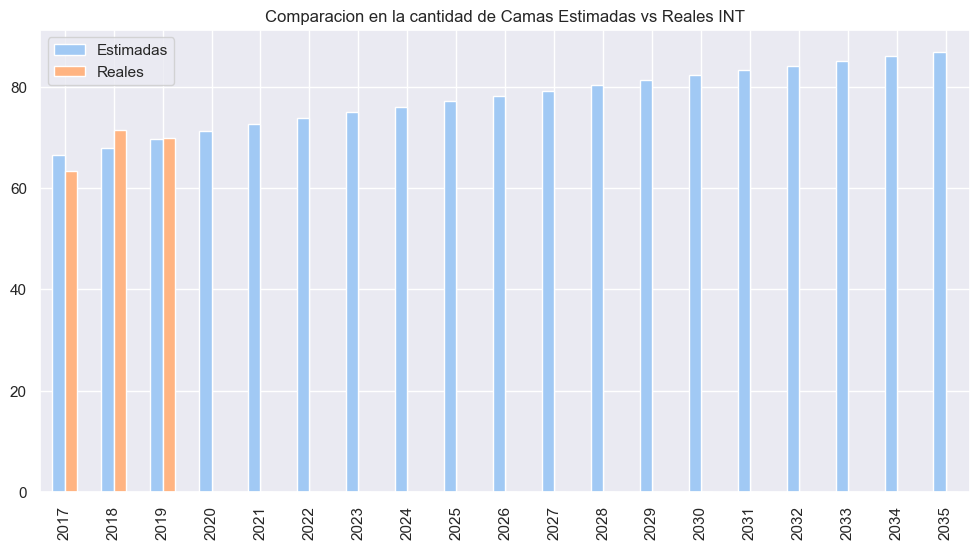

In [17]:
comparacion_camas.plot(kind="bar")
plt.title("Comparacion en la cantidad de Camas Estimadas vs Reales INT")
plt.show()

En este caso, se muestra la cantidad de camas que necesitaría el INT para atender los problemas de salud relevantes. Cabe destacar que esta es la cantidad de camas siguiendo solamente el crecimiento natural de la población, sin ningún cierre de brecha.

Sin embargo, es importante notar la labor sanitaria del INT, y su compromiso con el cierre de brechas. Por lo tanto, es necesario saber en que problemas de salud existe una brecha de atención a nivel nacional.

In [18]:
porcentaje_atencion_teorica_nacional = (
    metricas_diags_relevantes_nacionales["n_pacientes_distintos"]
    .sum(axis=1)
    .div(casos_pais_del_2017_al_2020.sum(axis=1), axis=0)
) * 100

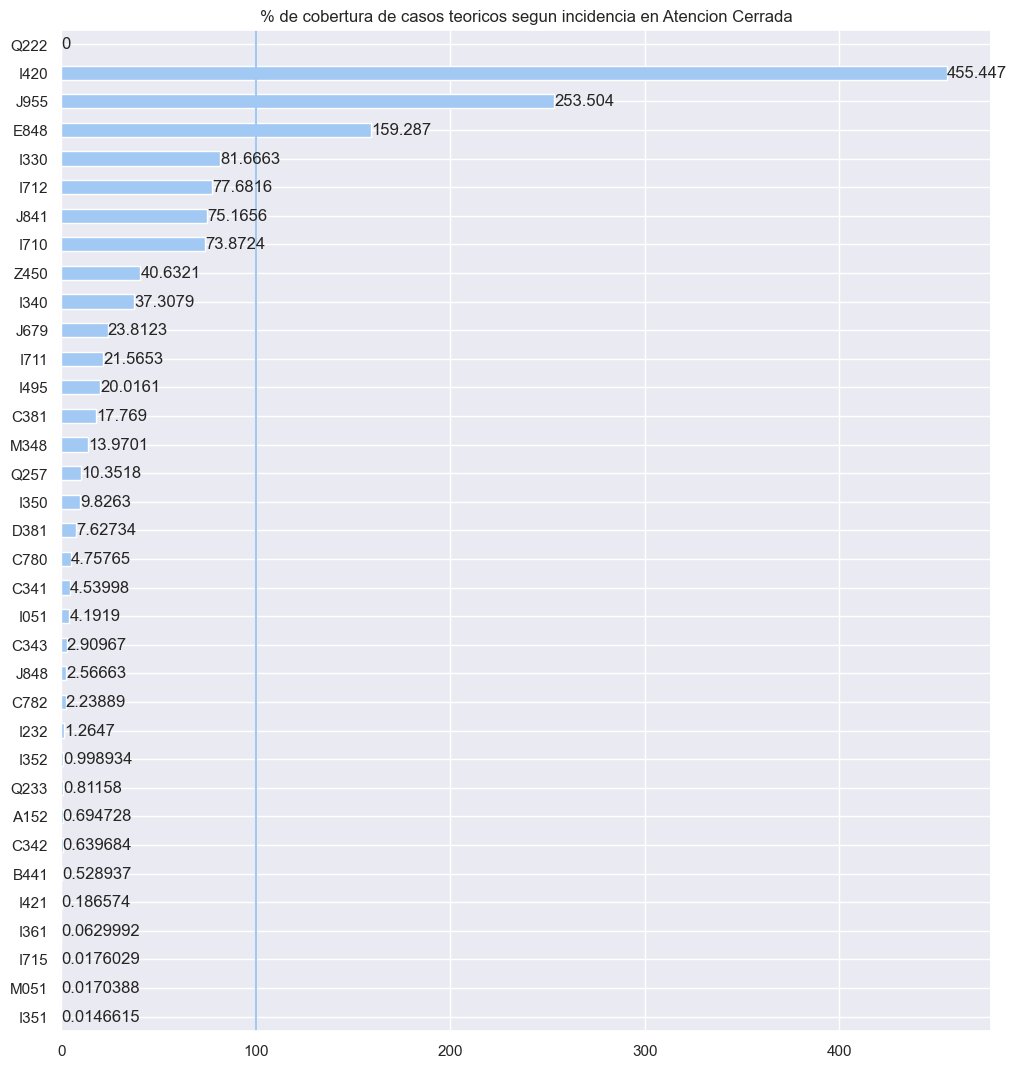

In [19]:
fig, axis = plt.subplots(figsize=(12, 13))
porcentaje_atencion_teorica_nacional.sort_values().plot(kind="barh", ax=axis)
for i in axis.containers:
    axis.bar_label(i)

plt.axvline(100)
plt.title("% de cobertura de casos teoricos segun incidencia en Atencion Cerrada")
plt.show()